In [2]:
import os
import re
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [3]:
direccion='../limpiezacolumnas/salida/'

In [4]:
dd=pd.DataFrame()
for path, subdirs, files in os.walk(direccion):
        for name in tqdm(files):
            if(len(name)<8):
                print(name)
            
                df=pd.read_csv(os.path.join(path, name))
                df["Hora"]=pd.to_datetime(df["Hora"],dayfirst=True)
                df = df.set_index('Hora')
                ix=df.index.values-3
                imputer = KNNImputer(n_neighbors=6)
                df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
                df['index']=ix
                dff = df.set_index('index')
                df=pd.melt(df, id_vars=['index'], var_name='NIS', value_name='KWh')
                df["cat"]=name[:3]
                
                dd = pd.concat([dd, df],axis=0)
                  #df["Hora"] 

 17%|█▋        | 1/6 [00:00<00:00,  6.02it/s]

141.csv
142.csv


 67%|██████▋   | 4/6 [00:00<00:00, 10.64it/s]

245.csv
343.csv
546.csv


100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]

846.csv


In [5]:

dd['hour'] = dd['index'].apply(lambda x: x.hour)

In [6]:
dd['day'] = dd['index'].apply(lambda x: x.dayofweek)

In [7]:
dd.head()

,index,NIS,KWh,cat,hour,day
0,2021-12-01 00:59:59.999999997,1572256,0.052,141,0,2
1,2021-12-01 01:59:59.999999997,1572256,0.046,141,1,2
2,2021-12-01 02:59:59.999999997,1572256,0.042,141,2,2
3,2021-12-01 03:59:59.999999997,1572256,0.044,141,3,2
4,2021-12-01 04:59:59.999999997,1572256,0.052,141,4,2


In [8]:
dd['max_KWh'] = dd.groupby(['cat'])['KWh'].transform(max)

In [9]:
dd['norm_KWh'] = dd['KWh'] / dd['max_KWh']

In [10]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None,fig=None,ax=None):
    if(fig==None and ax==None):
        fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

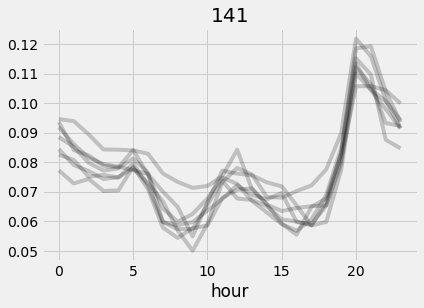

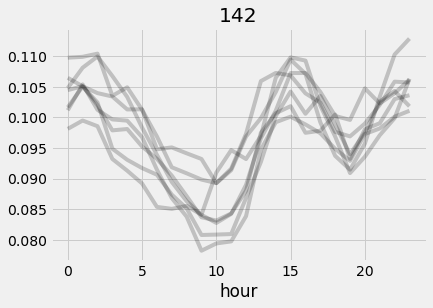

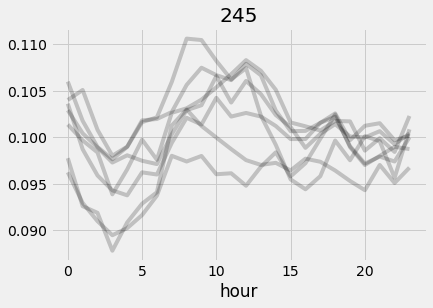

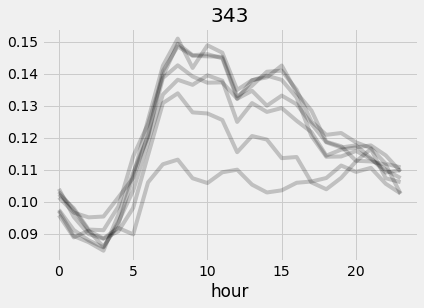

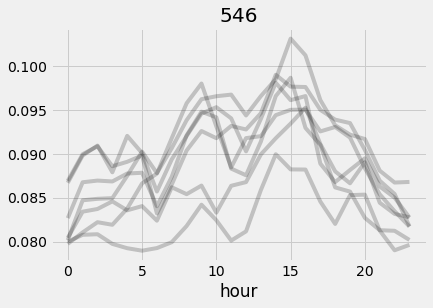

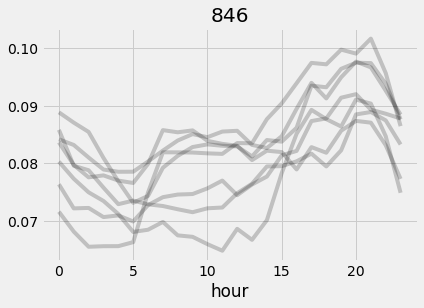

In [11]:
for cat in np.unique(dd.cat):
    multiline_hourly_plot(dd[dd.cat == cat].groupby('day'),ycol = 'norm_KWh',opacity =0.2,title=cat)

In [12]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

In [14]:
red_df = dd[['cat','NIS',  'day', 'hour', 'norm_KWh']]

In [15]:
piv_df =pd.pivot_table(red_df, index = ['cat','NIS'], columns = ['hour','day'], values = 'norm_KWh') #pd.pivot_table(red_df, index = ['cat','NIS',  'day'], columns = 'hour', values = 'norm_KWh')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['cat','NIS']).mean()
grp_df.reset_index(inplace = True)
#del grp_df['day'] # This feature is not relevant any more

D:\UserFiles\anaconda\envs\ia\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
grp_df.head()

hour  cat      NIS         0                                          \
day                        0         1         2         3         4   
0     141  1007512  0.095722  0.070441  0.076232  0.082455  0.065514   
1     141  1009970  0.024201  0.011884  0.024201  0.021608  0.021953   
2     141  1010209  0.180640  0.171997  0.169749  0.176664  0.192740   
3     141  1013464  0.037597  0.042783  0.041832  0.036992  0.045462   
4     141  1015235  0.148660  0.121651  0.122731  0.154710  0.128608   

hour                             1                                          \
day          5         6         0         1         2         3         4   
0     0.092697  0.074330  0.096586  0.071089  0.076577  0.082973  0.067243   
1     0.011668  0.023552  0.022904  0.011020  0.022299  0.023682  0.025411   
2     0.193604  0.169620  0.181072  0.185177  0.183578  0.170095  0.179430   
3     0.040622  0.035004  0.034356  0.039758  0.039931  0.038721  0.045117   
4     0.111279  0.125324  0.133103  0.107606  0.122731  0.139499  0.131547   

hour                             2                                          \
day          5         6         0         1         2         3         4   
0     0.093129  0.075194  0.099179  0.081245  0.076923  0.084702  0.063613   
1     0.011236  0.021824  0.022472  0.011236  0.021089  0.024028  0.025929   
2     0.203544  0.171564  0.178479  0.179127  0.156612  0.152118  0.159723   
3     0.037813  0.038245  0.039326  0.034788  0.035609  0.038029  0.044944   
4     0.095073  0.103933  0.128133  0.097450  0.107865  0.129991  0.114780   

hour                             3                                          \
day          5         6         0         1         2         3         4   
0     0.095938  0.075411  0.098963  0.083621  0.077615  0.085220  0.064650   
1     0.010804  0.022256  0.016638  0.011884  0.022818  0.025065  0.026966   
2     0.189067  0.175238  0.168755  0.181504  0.174762  0.174935  0.174589   
3     0.039326  0.035436  0.042999  0.037165  0.042178  0.035955  0.047882   
4     0.091400  0.092264  0.112143  0.095073  0.099049  0.121348  0.117027   

hour                             4                                          \
day          5         6         0         1         2         3         4   
0     0.100908  0.077571  0.086214  0.090320  0.078133  0.079516  0.067761   
1     0.011668  0.021824  0.017286  0.011668  0.021953  0.024719  0.023855   
2     0.195117  0.158168  0.174589  0.171132  0.170959  0.148487  0.161452   
3     0.037597  0.037813  0.042999  0.046024  0.041832  0.039239  0.053241   
4     0.093777  0.085566  0.111711  0.092913  0.114434  0.128090  0.108902   

hour                             5                                          \
day          5         6         0         1         2         3         4   
0     0.096370  0.078436  0.066335  0.051426  0.077787  0.058600  0.063613   
1     0.011668  0.023120  0.017286  0.013613  0.022299  0.021780  0.023682   
2     0.194468  0.167243  0.211322  0.242653  0.177010  0.190320  0.203457   
3     0.038245  0.039326  0.045376  0.045160  0.041832  0.043215  0.040104   
4     0.071089  0.083838  0.193388  0.186906  0.155229  0.167675  0.139499   

hour                             6                                          \
day          5         6         0         1         2         3         4   
0     0.087727  0.059637  0.027874  0.005618  0.032325  0.012965  0.015557   
1     0.011452  0.024201  0.019447  0.011236  0.021953  0.038029  0.021780   
2     0.205056  0.189499  0.202247  0.277874  0.162489  0.175281  0.267070   
3     0.038029  0.040190  0.041271  0.026145  0.017978  0.041487  0.020398   
4     0.108470  0.085134  0.122515  0.093129  0.090061  0.125151  0.096111   

hour                             7                                          \
day          5         6         0         1         2         3         4   
0     0.041054  0.022256  0.003889  0.003025  0.002074  0

In [73]:
kmeans_df = grp_df#pd.get_dummies(grp_df, columns =['cat','NIS'])

In [74]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

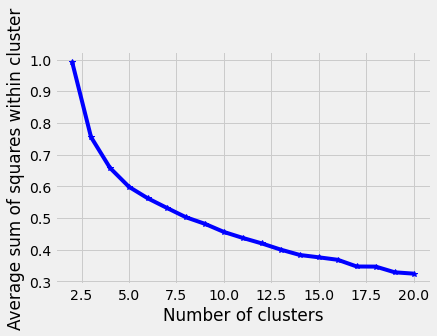

In [75]:
k_algs, k_res = elbow_method(kmeans_df.drop(['cat', 'NIS'], axis = 1), 2, 20)

In [76]:
algorithm = k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[4]

In [77]:
clustering.cluster_centers_

array([[0.02386357, 0.02290284, 0.02318825, ..., 0.02445427, 0.02414618,
        0.0245764 ],
       [0.25512949, 0.26825064, 0.25139912, ..., 0.26048125, 0.25467632,
        0.2542877 ],
       [0.08532342, 0.07864328, 0.07887599, ..., 0.0887362 , 0.09176312,
        0.0898508 ],
       [0.47137993, 0.50884102, 0.51192516, ..., 0.54941718, 0.5501778 ,
        0.51091806],
       [0.1249976 , 0.12669846, 0.12976498, ..., 0.14076296, 0.12541272,
        0.13522384],
       [0.20819436, 0.20499941, 0.20916374, ..., 0.19057321, 0.19873455,
        0.19963922]])

In [78]:
cls_list = algorithm.predict(kmeans_df.drop(['cat', 'NIS'], axis = 1))

D:\UserFiles\anaconda\envs\ia\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [79]:
kmeans_df['cluster'] = cls_list

In [80]:
def print_building_types_in_clusters(data):
    for tp in data['cat'].unique():
        print('How many cat of type', tp, 'are in each cluster?')
        print(data[data.cat == tp]['cluster'].value_counts())

In [81]:
print_building_types_in_clusters(kmeans_df)

How many cat of type 141 are in each cluster?
2    19
0    17
5     6
4     3
Name: cluster, dtype: int64
How many cat of type 142 are in each cluster?
0    36
2    32
5    19
4    18
1     6
Name: cluster, dtype: int64
How many cat of type 245 are in each cluster?
0    53
2    22
1    12
4    10
5     8
3     2
Name: cluster, dtype: int64
How many cat of type 343 are in each cluster?
0    25
2    14
4    12
1     8
5     6
3     2
Name: cluster, dtype: int64
How many cat of type 546 are in each cluster?
0    42
2    21
4    11
1     8
5     6
3     1
Name: cluster, dtype: int64
How many cat of type 846 are in each cluster?
0    24
2    12
4     2
1     2
3     2
5     1
Name: cluster, dtype: int64


In [82]:
def make_cluster_table(data):
    tbl = data[['cat', 'cluster']]
    tbl_grp = tbl.groupby(tbl.columns.tolist(), as_index = False).size()
    tbl_frm = tbl_grp#.reset_index().drop('index')
    
    tbl_frm.columns = ['cat', 'cluster','count']
    tbl_pvt = pd.pivot_table(tbl_frm, index = 'cat', columns = 'cluster', values = 'count').fillna(0).astype(int)
    return (tbl_frm, tbl_pvt)

In [83]:
tbl_frm, tbl_pvt = make_cluster_table(kmeans_df)
tbl_pvt

cluster,0,1,2,3,4,5
cat,,,,,,
141,17,0,19,0,3,6
142,36,6,32,0,18,19
245,53,12,22,2,10,8
343,25,8,14,2,12,6
546,42,8,21,1,11,6
846,24,2,12,2,2,1


In [84]:


from matplotlib.ticker import MaxNLocator

def cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['count'])
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq)
    plt.show()



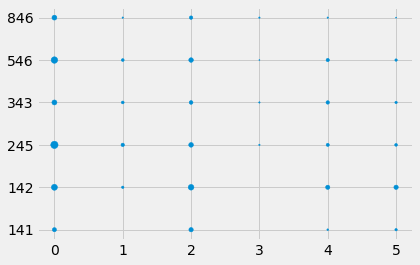

In [85]:
cluster_scatter_plot(tbl_frm)

In [86]:
 tbl_frm.head()

,cat,cluster,count
0,141,0,17
1,141,2,19
2,141,4,3
3,141,5,6
4,142,0,36


In [87]:
def compute_building_share(original_df, kmeans_df, tbl_frm):
    bld_share = {}
    for tp in original_df['cat'].unique():
        tot_num_buildings = len(original_df[original_df.cat == tp].groupby('NIS'))
        bld_share[tp] = {}
        for c in kmeans_df['cluster'].unique():
            nb = tbl_frm[(tbl_frm.cat == tp) & (tbl_frm.cluster == c)]['count']
            if not nb.empty:
                bld_share[tp][c] = int(nb) / tot_num_buildings
    return bld_share

In [88]:
bld_share = compute_building_share(dd, kmeans_df, tbl_frm)
tbl_frm['bld_pct'] = tbl_frm.apply(lambda row: bld_share[row['cat']][row['cluster']], axis = 1)

In [89]:
def norm_cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['bld_pct'].apply(lambda x: x * 100))
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq);

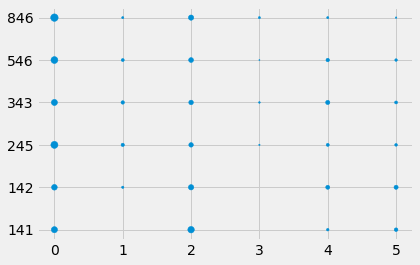

In [90]:
norm_cluster_scatter_plot(tbl_frm)

In [91]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

hour,cat,NIS,cluster,day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,141,1007512,0,0,0.095722,0.096586,0.099179,0.098963,0.086214,0.066335,0.027874,0.003889,0.003025,0.003241,0.002377,0.007131,0.005618,0.004538,0.002161,0.001513,0.001152,0.001296,0.001296,0.005618,0.019447,0.023336,0.064607,0.068928
1,141,1007512,0,1,0.070441,0.071089,0.081245,0.083621,0.090320,0.051426,0.005618,0.003025,0.002809,0.002593,0.001513,0.002593,0.004970,0.002809,0.001945,0.001945,0.002161,0.001945,0.005402,0.011236,0.023984,0.041919,0.061150,0.069793
2,141,1007512,0,2,0.076232,0.076577,0.076923,0.077615,0.078133,0.077787,0.032325,0.002074,0.000864,0.001037,0.001037,0.001901,0.001729,0.001901,0.000864,0.001037,0.001037,0.001037,0.001037,0.021262,0.047018,0.061020,0.076059,0.082455
3,141,1007512,0,3,0.082455,0.082973,0.084702,0.085220,0.079516,0.058600,0.012965,0.001037,0.000519,0.000691,0.000864,0.001210,0.001037,0.000864,0.001037,0.000691,0.000691,0.007087,0.013656,0.023682,0.040104,0.040277,0.042178,0.058773
4,141,1007512,0,4,0.065514,0.067243,0.063613,0.064650,0.067761,0.063613,0.015557,0.000691,0.000691,0.001210,0.001037,0.001037,0.001037,0.001037,0.001556,0.000691,0.000691,0.000691,0.000864,0.016768,0.035782,0.048574,0.083146,0.095506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,846,2833495,2,2,0.055714,0.055621,0.054610,0.053642,0.058864,0.081151,0.099907,0.117295,0.088232,0.077772,0.073985,0.093794,0.095882,0.110995,0.119910,0.111572,0.093963,0.075217,0.065020,0.070929,0.068730,0.064187,0.062320,0.059475
3230,846,2833495,2,3,0.058261,0.058558,0.057285,0.053761,0.054135,0.080608,0.116777,0.107752,0.101494,0.085677,0.071922,0.072287,0.071676,0.081015,0.084853,0.094303,0.096256,0.102717,0.078222,0.067669,0.057200,0.059042,0.055604,0.055060
3231,846,2833495,2,4,0.054958,0.052725,0.051774,0.061335,0.070793,0.095712,0.109153,0.109000,0.100119,0.078434,0.067635,0.085116,0.098591,0.106707,0.089039,0.087570,0.077976,0.065223,0.068263,0.072185,0.059976,0.054738,0.053405,0.047748
3232,846,2833495,2,5,0.047132,0.046963,0.047016,0.045169,0.043046,0.051738,0.066628,0.073983,0.079704,0.058923,0.049945,0.043450,0.048968,0.048735,0.046909,0.050741,0.045042,0.049966,0.053383,0.064463,0.063084,0.051898,0.049043,0.049552


In [210]:
def clusters_visualisation(kmeans_df, id_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars =kmeans_df.columns, var_name = ['hour'], value_name = 'norm_KWh')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_KWh', opacity = 0.1, title = 'Cluster ' + str(c))

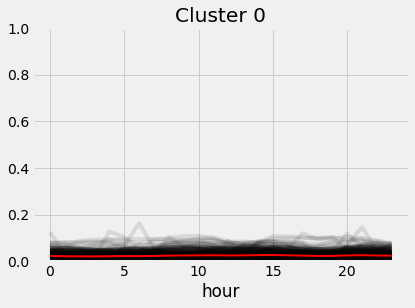

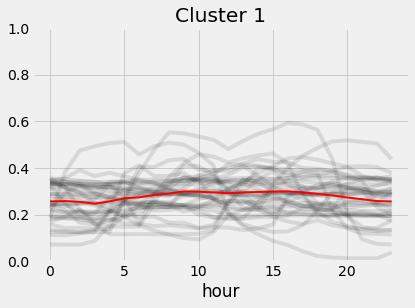

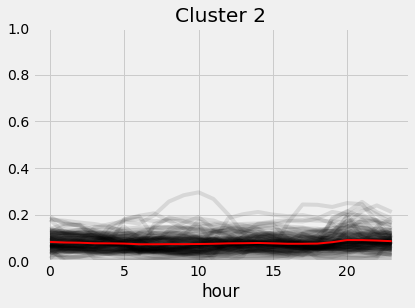

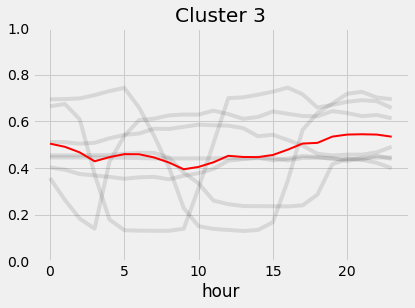

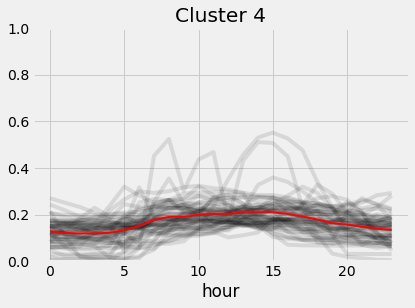

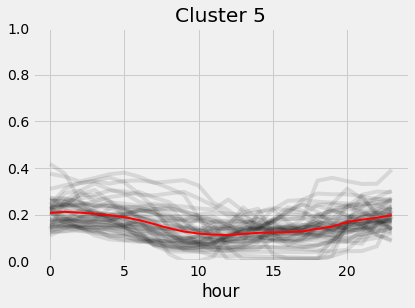

In [211]:
ddd=kmeans_df.set_index(['cat','NIS','cluster']).stack(level=1).reset_index().groupby(['cat','NIS','cluster']).mean().reset_index()
clusters_visualisation(ddd, id_vars = ['cat', 'NIS', 'cluster'])